In [63]:
import pandas as pd
import seaborn as sns
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

topk_ratio = 0.15

In [64]:
with open('./stats_data/ndf2.pkl', 'rb') as f:
    ndf2 = pkl.load(f)

In [65]:
aid2info = {}
for aid, a in ndf2.groupby('agent_id'):
    dic = {}
    dic['callback'] = len(a[a.adjusted_callback_period_days <= 2])
    dic['total'] = len(a)
    dic['ratio'] = dic['callback'] / dic['total']
    aid2info[aid] = dic
adf = pd.DataFrame.from_dict(aid2info, orient='index').reset_index().rename(columns={'index': 'agent_id'})
ndf2['callback'] = np.where(ndf2.adjusted_callback_period_days <= 2, 'cb', 'ncb')

In [66]:
min_total = adf.total.quantile(0.1)
adf = adf[adf.total >= min_total]

rate = adf.ratio.quantile(topk_ratio)
msa = adf[adf.ratio <= rate]

rate = adf.ratio.quantile(1-topk_ratio)
lsa = adf[adf.ratio >= rate]

msa = msa.merge(ndf2, on='agent_id', how='left')
lsa = lsa.merge(ndf2, on='agent_id', how='left')
msa['call_len_ratio'] = msa.call_len / msa.call_len.max()
lsa['call_len_ratio'] = msa.call_len / lsa.call_len.max()

In [67]:
msa['conv_portion'] = pd.qcut(msa['call_len'], q=10, labels=[i for i in range(10)]).astype(int)
lsa['conv_portion'] = pd.qcut(lsa['call_len'], q=10, labels=[i for i in range(10)]).astype(int)
msa['agent_type'] = np.where(msa.adjusted_callback_period_days <= 2, 'msa_cb', 'msa_ncb')
lsa['agent_type'] = np.where(lsa.adjusted_callback_period_days <= 2, 'lsa_cb', 'lsa_ncb')
msa.call_len = msa.call_len.apply(lambda x: x.total_seconds())
lsa.call_len = lsa.call_len.apply(lambda x: x.total_seconds())
adf = pd.concat([msa, lsa])

In [68]:
print('number of calls =', len(adf))
print('number of msa calls = ', len(msa))
print('number of lsa calls = ', len(lsa))
print('number of all calls = ', len(ndf2))
print(msa['agent_type'].value_counts(normalize=True))
print(lsa['agent_type'].value_counts(normalize=True))
print(ndf2['callback'].value_counts(normalize=True))

number of calls = 221917
number of msa calls =  77030
number of lsa calls =  144887
number of all calls =  1246436
msa_ncb    0.982942
msa_cb     0.017058
Name: agent_type, dtype: float64
lsa_ncb    0.839751
lsa_cb     0.160249
Name: agent_type, dtype: float64
ncb    0.912868
cb     0.087132
Name: callback, dtype: float64


In [69]:
adf

,agent_id,callback_x,total,ratio,recoverykey,masked_customerid_all,start_time_obj,end_time_obj,transcript_exist,sourcemediaid,...,global_len,local_len,sub_local_len,callcenter,agent_counts,call_len,callback_y,call_len_ratio,conv_portion,agent_type
0,100106,0,19,0.000000,9205216609046,2845102,2020-03-28 14:10:32,2020-03-28 14:24:37,True,264726032,...,1,1,1,Oakland_15,19,845.0,ncb,0.048488,6,msa_ncb
1,100106,0,19,0.000000,9205217570869,2781519,2020-03-29 08:39:00,2020-03-29 09:27:41,True,264843264,...,1,1,1,Richmond_8,19,2921.0,ncb,0.167613,9,msa_ncb
2,100106,0,19,0.000000,9205201482570,4284198,2020-03-22 14:26:50,2020-03-22 14:35:52,True,263562814,...,2,1,2,Wichita_14,19,542.0,ncb,0.031101,4,msa_ncb
3,100106,0,19,0.000000,9205201470179,6701379,2020-03-22 14:24:39,2020-03-22 14:29:55,True,263562666,...,1,1,1,Colorado Springs_2,19,316.0,ncb,0.018133,1,msa_ncb
4,100106,0,19,0.000000,9205217738818,5398532,2020-03-29 10:42:36,2020-03-29 11:00:18,True,264858485,...,2,1,2,Nashville_14,19,1062.0,ncb,0.060940,7,msa_ncb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144882,ÿ481029,17,119,0.142857,9194170369695,3561983,2020-03-06 18:22:57,2020-03-06 18:32:36,True,259547862,...,4,4,1,Springfield_7,119,579.0,cb,NaN,5,lsa_cb
144883,ÿ481029,17,119,0.142857,9201165367704,4128264,2020-03-11 10:27:59,2020-03-11 10:38:18,True,261000891,...,2,2,1,Springfield_7,119,619.0,ncb,NaN,5,lsa_ncb
144884,ÿ481029,17,119,0.142857,9182214744031,3593502,2020-03-03 18:33:20,2020-03-03 18:42:09,True,258527388,...,1,1,1,Springfield_7,119,529.0,ncb,NaN,4,lsa_ncb
144885,ÿ481029,17,119,0.142857,9199348566818,4765819,2020-03-10 12:12:32,2020-03-10 12:19:24,True,260735355,...,1,1,1,Springfield_7,119,412.0,ncb,NaN,3,lsa_ncb


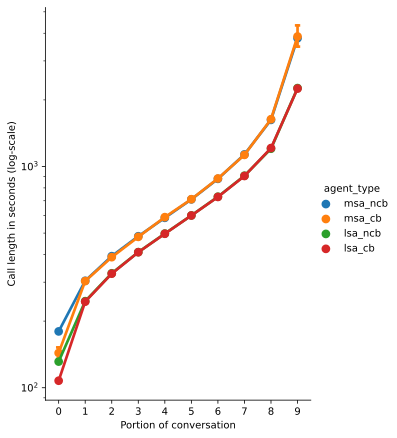

In [38]:
g = sns.catplot(
    data=adf,
    x='conv_portion', y='call_len', hue='agent_type',
    height=6,
    capsize=.1,
    kind='point',
    aspect=.75,
    linewidth = 0.5,
)
g.set_axis_labels("Portion of conversation", "Call length in seconds (log-scale)")
g.set(yscale='log')

In [55]:
min_call_len = adf.call_len.quantile(0.02)
max_call_len = adf.call_len.quantile(0.98)
print('before filtering, # of calls = ', len(adf))
adf2 = adf[(adf.call_len >= min_call_len) & (adf.call_len <= max_call_len)]
print('after filtering, # of calls = ', len(adf2))

before filtering, # of calls =  221917
after filtering, # of calls =  213076


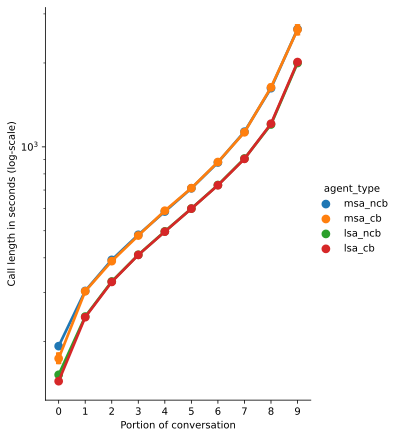

In [56]:
g = sns.catplot(
    data=adf2,
    x='conv_portion', y='call_len', hue='agent_type',
    height=6,
    capsize=.1,
    kind='point',
    aspect=.75,
    linewidth = 0.5,
)
g.set_axis_labels("Portion of conversation", "Call length in seconds (log-scale)")
g.set(yscale='log')

In [19]:
msa.to_csv(f'./stats_data/msa_{topk_ratio:.2f}.csv', sep='|')
lsa.to_csv(f'./stats_data/lsa_{topk_ratio:.2f}.csv', sep='|')